<a href="https://colab.research.google.com/github/shobhit-saini/Neural_Network/blob/master/communications_from_a_speech_impaired_person_to_someone_who_doesn't_understand_sign_language/code/Mini_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

y = 4


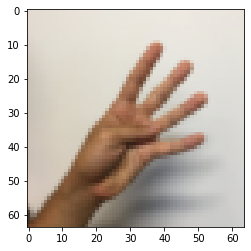

In [0]:
import numpy as np
import h5py
import math
import matplotlib.pyplot as plt
def load_dataset():
    #Train Set Dataset
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    #Test set Dataset
    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig = load_dataset()
'''
Dims:
train_set_x_orig: (1080, 64, 64, 3)
train_set_y_orig: (1, 1080)
test_set_x_orig: (120, 64, 64, 3)
test_set_y_orig: (1, 120)
flatten_train_set_x: (12288, 1080)
flatten_test_set_y: (12288, 120)
training_output:(6, 1080)
'''

#Analyze the data

plt.imshow(train_set_x_orig[30])
print ("y = " + str(np.squeeze(train_set_y_orig[:, 30])))

#Converting each dataset in column vector
flatten_train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
flatten_test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
#One hot encoding
training_output = []
for i in train_set_y_orig[:][0]:
  tmp = np.zeros(6)
  tmp[i] = 1.0
  training_output.append(tmp)
training_output = np.array(training_output)
training_output = training_output.T

#Normalize the dataset
flatten_train_set_x = (flatten_train_set_x - flatten_train_set_x.mean(axis = 0))/flatten_train_set_x.std(0)
flatten_test_set_x = (flatten_test_set_x - flatten_test_set_x.mean(axis = 0))/flatten_test_set_x.std(0)

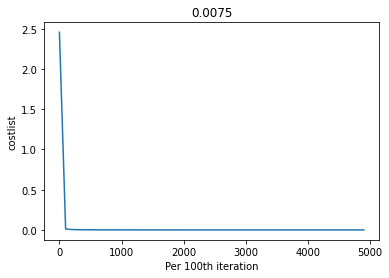

In [0]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def relu(x):
  return np.maximum(0,x)
def relu_prime(x):
  return np.where(x > 0, 1.0, 0.0)
#Define features of each layer
Input_layer_features = flatten_train_set_x.shape[0]
First_hidden_layer_features = 100
Second_hidden_layer_features = 50
Output_features = 6
m = flatten_train_set_x.shape[1]

#Define Hyperparaameters
learning_rate = 0.0075
minibatch_size = 64
#Define parameters
W1 = np.random.randn(First_hidden_layer_features, Input_layer_features)*np.sqrt(2/(Input_layer_features)) #(100, 12288)
W2 = np.random.randn(Second_hidden_layer_features, First_hidden_layer_features)*np.sqrt(2/First_hidden_layer_features)#(50, 100)
W3 = np.random.randn(Output_features, Second_hidden_layer_features)*np.sqrt(1/Second_hidden_layer_features)#(6, 50)
b1 = np.zeros((First_hidden_layer_features, 1))#(100, 1)
b2 = np.zeros((Second_hidden_layer_features, 1))#(50, 1)
b3 = np.zeros((Output_features, 1))#(6, 1)

# Step 1: Shuffle (X, Y)
permutation = list(np.random.permutation(m))
shuffled_X = flatten_train_set_x[:, permutation]
shuffled_Y = training_output[:, permutation]

mini_batches = []
Number_of_complete_minibatch = math.floor(m/minibatch_size)

for i in range(Number_of_complete_minibatch):
  mini_batch_X = shuffled_X[:, i*minibatch_size: (i+1)*minibatch_size]
  mini_batch_Y = shuffled_Y[:, i*minibatch_size : (i+1)*minibatch_size]
  mini_batch = (mini_batch_X, mini_batch_Y)
  mini_batches.append(mini_batch)

flag = 0
if m % minibatch_size != 0:
  flag = 1
  mini_batch_X = shuffled_X[:, i*minibatch_size : (i*minibatch_size + (m-(minibatch_size*math.floor(m/minibatch_size))))] 
  mini_batch_Y = shuffled_Y[:, i*minibatch_size : (i*minibatch_size + (m-(minibatch_size*math.floor(m/minibatch_size))))]
  mini_batch = (mini_batch_X, mini_batch_Y)
  mini_batches.append(mini_batch)  

if flag == 1:
  total_mini_batch = Number_of_complete_minibatch + 1
else:
  total_mini_batch = Number_of_complete_minibatch
costlist = []
iteration = []
for i in range(5000):
  loss = 0
  for j in range(total_mini_batch):
    X = mini_batches[j][0]
    Y = mini_batches[j][1]
    Z1 = np.dot(W1, X) + b1 
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2 
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3 
    A3 = softmax(Z3)
    '''__________________________Loss_Calculation_________________________________'''
    loss += -np.sum(np.multiply(Y, np.log(A3)) + np.multiply((1-Y), np.log(1-A3)))
    '''_________________________Back_Propagation__________________________________'''
    dZ3 = A3-Y
    assert( dZ3.shape == Z3.shape )
    dW3 = np.dot(dZ3, A2.T)/minibatch_size
    assert( dW3.shape == W3.shape )
    db3 = np.sum(dZ3, axis = 1, keepdims= True)/minibatch_size
    assert( db3.shape == b3.shape )
    dA2 = np.dot(W3.T, dZ3)
    assert( dA2.shape == A2.shape )
    dZ2 = np.multiply(dA2, relu_prime(Z2))
    assert(dZ2.shape == Z2.shape)
    dW2 = np.dot(dZ2, A1.T)/minibatch_size
    assert(dW2.shape == W2.shape)
    db2 = np.sum(dZ2, axis = 1, keepdims= True)/minibatch_size
    assert( db2.shape == b2.shape )
    dA1 = np.dot(W2.T, dZ2)
    assert(dA1.shape == A1.shape)
    dZ1 = np.multiply(dA1, relu_prime(Z1))
    assert(dZ1.shape == Z1.shape)
    dW1 = np.dot(dZ1, X.T)/minibatch_size
    assert(dW1.shape == W1.shape)
    db1 = np.sum(dZ1, axis = 1, keepdims= True)/minibatch_size
    assert(db1.shape == b1.shape)

    '''__________________________Update_Parameters________________________________'''
    W1 -= learning_rate*dW1
    W2 -= learning_rate*dW2
    W3 -= learning_rate*dW3
    b1 -= learning_rate*db1
    b2 -= learning_rate*db2
    b3 -= learning_rate*db3
  cost = loss/m
  if i %100 == 0:
    costlist.append(cost)
    iteration.append(i)

plt.plot(iteration, costlist)
plt.xlabel("Per 100th iteration")
plt.ylabel("costlist")
plt.title(learning_rate)
plt.show()


In [0]:
print(costlist)

[2.4569943360328717, 0.012037313026099658, 0.004790386377148398, 0.0028652845703863805, 0.0020050250630371212, 0.0015251850563473342, 0.0012216839810225341, 0.001013654089850592, 0.0008631319868550901, 0.0007495596215292743, 0.0006608865251743148, 0.0005900024989237058, 0.0005321335040220493, 0.00048401386448248016, 0.0004433486335987665, 0.0004086285490425799, 0.00037867266410135386, 0.00035257658494128465, 0.0003296552187960044, 0.0003093406557232763, 0.000291259108298873, 0.00027508464229933713, 0.0002605087094660417, 0.0002473155098758817, 0.00023532534585579668, 0.00022438147713008496, 0.0002143596104955101, 0.00020514346515406124, 0.00019664790090973382, 0.0001887848654476172, 0.00018149248726925696, 0.00017470848154776145, 0.00016838186596131624, 0.00016247566802353312, 0.00015694599414465922, 0.0001517613380634497, 0.00014689080976938812, 0.00014230447354673657, 0.00013798328085877474, 0.00013390309830410655, 0.00013004588010724288, 0.00012639026632480947, 0.0001229243600599114

In [0]:
def training_set_accuracy():
  Z1 = np.dot(W1, flatten_train_set_x) + b1 
  A1 = relu(Z1)
  Z2 = np.dot(W2, A1) + b2 
  A2 = relu(Z2)
  Z3 = np.dot(W3, A2) + b3
  A3 = softmax(Z3)
  out = np.argmax(A3,axis = 0)
  count = 0
  for i in range(1080):
    if out[i] == train_set_y_orig[0][i]:
      count = count + 1;
  print( "Number of training example correctly identified out of 1080:",count )
  accuracy = 100 - ((1080 - count)/m)*100 
  print( "Training Accuracy:", accuracy )
def test():
  Z1 = np.dot(W1, flatten_test_set_x) + b1 #(100, 1080) one column signifies value of Z1 due to one training example
  A1 = relu(Z1)
  Z2 = np.dot(W2, A1) + b2 #(50, 1080) 
  A2 = relu(Z2)
  Z3 = np.dot(W3, A2) + b3 #(6, 1080)
  A3 = softmax(Z3)
  out = np.argmax(A3,axis = 0)
  count = 0
  for i in range(120):
    if out[i] == test_set_y_orig[0][i]:
      count = count + 1;
  print("Number of test examples correctly identified out of 120:", count)
  accuracy = 100 - ((120 - count)/120)*100 
  print( "Test Accuracy:", accuracy )
training_set_accuracy()
test()

Number of training example correctly identified out of 1080: 1078
Training Accuracy: 99.81481481481481
Number of test examples correctly identified out of 120: 112
Test Accuracy: 93.33333333333333
